In [ ]:
!pwd

/


In [ ]:
from pyspark.sql import SparkSession
#spark=SparkSession.builder.getOrCreate()
spark = SparkSession.builder.master("local[4]").appName("DataFrame").getOrCreate()

In [ ]:
f = "gs://dongbucket/bigdata/cleaned_data.csv"

In [ ]:
df = spark.read.csv(f, inferSchema=True, header=True)

In [ ]:
df.show(5)

+---+----+-----+-------------------+----------+-----+------------+-----+---------+--------+-----+--------+--------------------+-----+------------+--------+----------+
|_c0|year| make|              model|      trim| body|transmission|state|condition|odometer|color|interior|              seller|  mmr|sellingprice|saledate|madeRegion|
+---+----+-----+-------------------+----------+-----+------------+-----+---------+--------+-----+--------+--------------------+-----+------------+--------+----------+
|  0|2015|  Kia|            Sorento|        LX|  suv|   automatic|   ca|      5.0| 16639.0|white|   black|kia motors americ...|20500|       21500|    2014|        5x|
|  1|2015|  Kia|            Sorento|        LX|  suv|   automatic|   ca|      5.0|  9393.0|white|   beige|kia motors americ...|20800|       21500|    2014|        5x|
|  2|2014|  BMW|           3 Series|328i SULEV|sedan|   automatic|   ca|      4.5|  1331.0| gray|   black|financial service...|31900|       30000|    2015|        wb

In [ ]:
df2 = df.drop('_c0')

In [ ]:
df2.printSchema()

root
 |-- year: integer (nullable = true)
 |-- make: string (nullable = true)
 |-- model: string (nullable = true)
 |-- trim: string (nullable = true)
 |-- body: string (nullable = true)
 |-- transmission: string (nullable = true)
 |-- state: string (nullable = true)
 |-- condition: double (nullable = true)
 |-- odometer: double (nullable = true)
 |-- color: string (nullable = true)
 |-- interior: string (nullable = true)
 |-- seller: string (nullable = true)
 |-- mmr: integer (nullable = true)
 |-- sellingprice: integer (nullable = true)
 |-- saledate: integer (nullable = true)
 |-- madeRegion: string (nullable = true)



In [ ]:
from pyspark import SparkContext
from pyspark.sql import SparkSession
from pyspark.sql.functions import isnull
from pyspark.ml.feature import Imputer
from pyspark.ml.feature import StringIndexer
from pyspark.ml.feature import OneHotEncoder
from pyspark.ml.feature import VectorAssembler
from pyspark.sql import types
from pyspark.sql.functions import *
from pyspark.ml.regression import LinearRegression
from pyspark.ml.regression import DecisionTreeRegressor
from pyspark.ml.regression import GBTRegressor
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.tuning import ParamGridBuilder
from pyspark.ml.tuning import CrossValidator

from pyspark.ml import Pipeline
from pyspark.ml.feature import OneHotEncoder
from pyspark.ml.feature import StringIndexer
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.feature import Normalizer

In [6]:
import pandas as pd
df2_python = pd.read_csv(f,usecols=lambda x: x != ' ', on_bad_lines='skip')

In [7]:
df2_python['sale_gap'] = df2_python['sellingprice']-df2_python['mmr']

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.pyplot import figure

df = df2_python
figure(figsize = (10, 6), dpi = 80)
plt.scatter(df[(df['sale_gap'] > -80000) & (df['sale_gap'] < 80000) ]['year'],df[(df['sale_gap'] > -80000) & (df['sale_gap'] < 80000)]['sale_gap'],c='#b0b75e')
plt.ylabel('Sale Gap')
plt.xlabel('Sale Year ')
plt.show()


In [ ]:
figure(figsize = (10, 6), dpi = 80)

df = df[(df['sale_gap'] > -80000) & (df['sale_gap'] < 80000) ]
plt.scatter(df['odometer'],df['sale_gap'],c='#b0b75e')
plt.ylabel('Sale Gap')
plt.xlabel('Odometer')
plt
plt.show()

In [ ]:
figure(figsize = (10, 6), dpi = 80)

fig = plt.figure()
fig.set_size_inches(10, 6, forward=True)
ax = fig.add_subplot()
ax.hist(df[(df['sale_gap'] > -3000) & (df['sale_gap'] < 3000) ]['sale_gap'], bins=50, alpha=0.7,color='#b0b75e')
ax.set_xlabel('Sale Gap', size =11)
ax.set_ylabel('Count', size =11)

plt.show()

In [ ]:
df2.withColumn('sale_gap', df2.sellingprice-df2.mmr).show()
df2 = df2.withColumn('sale_gap', df2.sellingprice-df2.mmr)
print(df2.dtypes)

+----+---------+-------------------+--------------------+-----------+------------+-----+------------------+--------+------+--------+--------------------+-----+------------+--------+----------+--------+
|year|     make|              model|                trim|       body|transmission|state|         condition|odometer| color|interior|              seller|  mmr|sellingprice|saledate|madeRegion|sale_gap|
+----+---------+-------------------+--------------------+-----------+------------+-----+------------------+--------+------+--------+--------------------+-----+------------+--------+----------+--------+
|2015|      Kia|            Sorento|                  LX|        suv|   automatic|   ca|               5.0| 16639.0| white|   black|kia motors americ...|20500|       21500|    2014|        5x|    1000|
|2015|      Kia|            Sorento|                  LX|        suv|   automatic|   ca|               5.0|  9393.0| white|   beige|kia motors americ...|20800|       21500|    2014|        5x|

In [ ]:
fieldIndex=["year","make","model","trim","body","transmission","state","condition","odometer","color","interior","saledate","sale_gap"]
df2=df2[fieldIndex]

In [ ]:
df2.describe().show()

+-------+------------------+------+-----------------+------------------+------+------------+------+------------------+------------------+------+--------+------------------+-------------------+
|summary|              year|  make|            model|              trim|  body|transmission| state|         condition|          odometer| color|interior|          saledate|           sale_gap|
+-------+------------------+------+-----------------+------------------+------+------------+------+------------------+------------------+------+--------+------------------+-------------------+
|  count|            544888|544888|           544888|            544888|544888|      544888|544888|            544888|            544888|544888|  544888|            544888|             544888|
|   mean|2010.1406123827282|  null|794.4347434743474|350.59835898183945|  null|        null|  null|  3.43614579266135| 67270.62719663738|  null|    null|2014.9047694205049|-159.97111700019087|
| stddev| 3.887146539603152|  null|

In [ ]:
print(df2.dtypes)

[('year', 'int'), ('make', 'string'), ('model', 'string'), ('trim', 'string'), ('body', 'string'), ('transmission', 'string'), ('state', 'string'), ('condition', 'double'), ('odometer', 'double'), ('color', 'string'), ('interior', 'string'), ('saledate', 'int'), ('sale_gap', 'int')]


In [ ]:
df2.printSchema()

root
 |-- year: integer (nullable = true)
 |-- make: string (nullable = true)
 |-- model: string (nullable = true)
 |-- trim: string (nullable = true)
 |-- body: string (nullable = true)
 |-- transmission: string (nullable = true)
 |-- state: string (nullable = true)
 |-- condition: double (nullable = true)
 |-- odometer: double (nullable = true)
 |-- color: string (nullable = true)
 |-- interior: string (nullable = true)
 |-- saledate: integer (nullable = true)
 |-- sale_gap: integer (nullable = true)



In [ ]:
make_stringIndexer_l=StringIndexer(inputCol="make", outputCol="makeIndex")
model_stringIndexer_l=StringIndexer(inputCol="model", outputCol="modelIndex")
trim_stringIndexer_l=StringIndexer(inputCol="trim", outputCol="trimIndex")
body_stringIndexer_l=StringIndexer(inputCol="body", outputCol="bodyIndex")
transmission_stringIndexer_l=StringIndexer(inputCol="transmission", outputCol="transmissionIndex")
state_stringIndexer_l=StringIndexer(inputCol="state", outputCol="stateIndex")
color_stringIndexer_l=StringIndexer(inputCol="color", outputCol="colorIndex")
interior_stringIndexer_l=StringIndexer(inputCol="interior", outputCol="interiorIndex")

make_hotEncoder=OneHotEncoder(inputCol="makeIndex", outputCol="makeVector")
model_hotEncoder=OneHotEncoder(inputCol="modelIndex", outputCol="modelVector")
trim_hotEncoder=OneHotEncoder(inputCol="trimIndex", outputCol="trimVector")
body_hotEncoder=OneHotEncoder(inputCol="bodyIndex", outputCol="bodyVector")
transmission_hotEncoder=OneHotEncoder(inputCol="transmissionIndex", outputCol="transmissionVector")
state_hotEncoder=OneHotEncoder(inputCol="stateIndex", outputCol="stateVector")
color_hotEncoder=OneHotEncoder(inputCol="colorIndex", outputCol="colorVector")
interior_hotEncoder=OneHotEncoder(inputCol="interiorIndex", outputCol="interiorVector")

assembler = VectorAssembler(inputCols=["year","makeVector","modelVector","trimVector","bodyVector","transmissionVector","stateVector","condition","odometer","colorVector","interiorVector","saledate"],outputCol='unNorm_features')

normalizer = Normalizer(inputCol="unNorm_features", outputCol="features", p=1.0)

pipeline = Pipeline(stages=[make_stringIndexer_l, model_stringIndexer_l,trim_stringIndexer_l,body_stringIndexer_l,transmission_stringIndexer_l,state_stringIndexer_l,color_stringIndexer_l,interior_stringIndexer_l,\
                            make_hotEncoder,model_hotEncoder,trim_hotEncoder,body_hotEncoder,transmission_hotEncoder,state_hotEncoder,color_hotEncoder,interior_hotEncoder,assembler,normalizer])

model=pipeline.fit(df2)
clean_data=model.transform(df2)
prepare_data=clean_data.select(["features","sale_gap"])

In [ ]:
train, test = prepare_data.randomSplit([0.7, 0.3])

In [ ]:
modelLR = linearRegression=LinearRegression(featuresCol='features',labelCol='sale_gap')
lrModel=modelLR.fit(train)

In [ ]:
trainingSummary=lrModel.summary
trainingSummary.predictions.show()

In [ ]:
test_results = lrModel.evaluate(test)
test_results.residuals.show()
print("RMSE: {}".format(test_results.rootMeanSquaredError))

+-------------------+
|          residuals|
+-------------------+
|  569.1476700931139|
| 1067.5012674952395|
|   683.553315949739|
| -696.0740105846753|
| 2768.8671431210714|
| 1200.5319370811212|
|  2335.341585996255|
|-21662.721599913864|
|-194.89521769164094|
|  152.2890679488355|
| -560.6731676291456|
| -1401.894121610465|
| -1112.112720671471|
|  694.2917912968223|
| -1167.696481492063|
|-1259.0941063045084|
| 1582.0906201438256|
| -730.4041763109876|
| 221.92755872793077|
| -842.8474889186236|
+-------------------+
only showing top 20 rows

RMSE: 1627.4098028299165


In [ ]:
print("R2: {}".format(test_results.r2))

R2: 0.11123531544625109


In [ ]:
decisionTreeRegression=DecisionTreeRegressor(featuresCol='features',labelCol='sale_gap',maxDepth=7)
modelDT=decisionTreeRegression.fit(train)
dfPDT=modelDT.transform(test)

In [ ]:
 dfPDT.show()

+--------------------+--------+-------------------+
|            features|sale_gap|         prediction|
+--------------------+--------+-------------------+
|(2438,[0,1,54,831...|    -250| 229.32448186528498|
|(2438,[0,1,54,831...|     800|-151.45778546210062|
|(2438,[0,1,54,831...|     200|-151.45778546210062|
|(2438,[0,1,54,831...|    -600| 391.91756743105367|
|(2438,[0,1,54,831...|    3000| 367.40659979648206|
|(2438,[0,1,54,831...|    1500|-151.45778546210062|
|(2438,[0,1,54,831...|    2700| 229.32448186528498|
|(2438,[0,1,54,831...|  -21200| 229.32448186528498|
|(2438,[0,1,54,831...|    -600|-40.827082131179075|
|(2438,[0,1,54,833...|      50| 104.53227141083988|
|(2438,[0,1,54,833...|    -800|  -612.655810384517|
|(2438,[0,1,54,833...|   -1625|-368.35322195704055|
|(2438,[0,1,54,833...|   -1525|-1252.6769825918761|
|(2438,[0,1,54,833...|    1050| 367.40659979648206|
|(2438,[0,1,54,833...|   -1375|  -612.655810384517|
|(2438,[0,1,54,833...|   -1550|  -807.145847871598|
|(2438,[0,1,

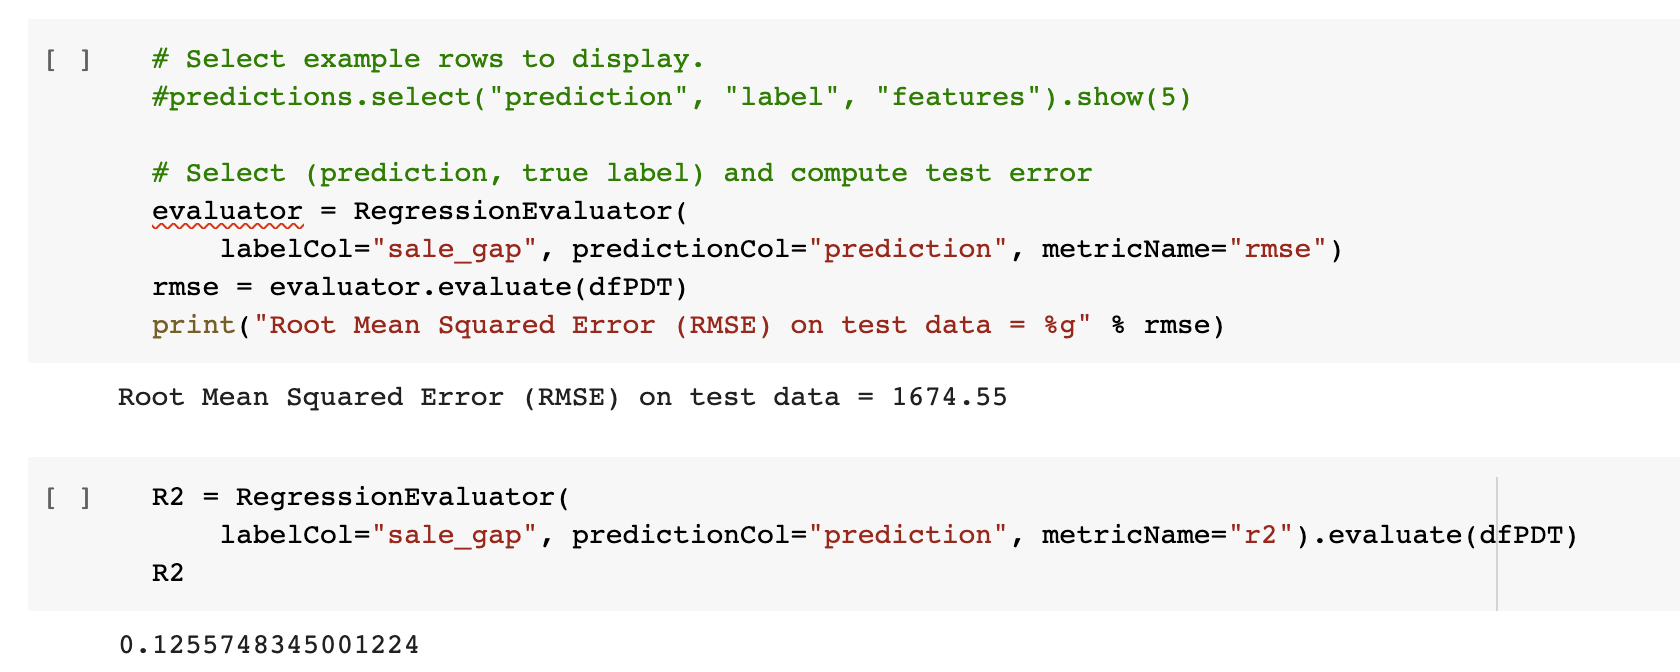